In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from typing import List, Dict, Tuple, Optional
import numpy as np
from typing import Dict, List
import numpy as np
from scipy.optimize import minimize
from typing import Tuple, Callable
import scipy.io as sio
import time


In [2]:
def m_step_cd(seq: np.recarray, x_dim: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    M-step update for C and d parameters in GPFA. Eq A8.
    """
    # Initialize sum of auto-covariances
    sum_Pauto = np.zeros((x_dim, x_dim))
    
    for trial in seq:
        sum_Pauto += (np.sum(trial.Vsm, axis=2) + 
                     trial.xsm @ trial.xsm.T)
    
    # Stack observations and states
    Y = np.hstack([trial.y for trial in seq])  # Stack all y_:t
    Xsm = np.hstack([trial.xsm for trial in seq])  # Stack all x_:t
    
    # Compute cross terms
    sum_yxtrans = Y @ Xsm.T  # ∑y_:t⟨x_:t⟩'
    sum_xall = np.sum(Xsm, axis=1)  # ∑⟨x_:t⟩
    sum_yall = np.sum(Y, axis=1)  # ∑y_:t
    
    # Construct block matrix for inversion (equation A8)
    term = np.block([
        [sum_Pauto, sum_xall[:, None]],
        [sum_xall[None, :], np.sum([trial.T for trial in seq])]
    ])
    
    # Compute [C d] using equation A8
    Cd = np.hstack([sum_yxtrans, sum_yall[:, None]]) @ np.linalg.inv(term)
    
    # Split result into C and d
    C = Cd[:, :x_dim]
    d = Cd[:, -1]
    
    return C, d

In [3]:
def m_step_R(seq: np.recarray, C: np.ndarray, d: np.ndarray, force_diagonal: bool = True) -> np.ndarray:
    """
    M-step update for observation noise covariance R in GPFA. Eq A9.
    """
    # Stack all observations and states
    Y = np.hstack([trial.y for trial in seq])  # Stack all y_:t
    Xsm = np.hstack([trial.xsm for trial in seq])  # Stack all ⟨x_:t⟩
    
    # Get total number of timepoints
    T = sum(trial.T for trial in seq)
    
    if force_diagonal:
        # Compute diagonal elements efficiently
        sum_yytrans = np.sum(Y * Y, axis=1)  # Sum of squared observations
        sum_yall = np.sum(Y, axis=1)  # Sum of observations
        sum_xall = np.sum(Xsm, axis=1)  # Sum of latent states
        
        # Compute yd term
        yd = sum_yall * d
        
        # Compute cross term
        sum_yxtrans = Y @ Xsm.T  # ∑y_:t⟨x_:t⟩'
        term = np.sum((sum_yxtrans - np.outer(d, sum_xall)) * C, axis=1)
        
        # Compute diagonal R (equation A9)
        r = (d**2 + (sum_yytrans - 2*yd - term) / T)
        R = np.diag(r)
        
    else:
        # Compute full covariance matrix
        sum_yytrans = Y @ Y.T  # ∑y_:ty_:t'
        sum_yall = np.sum(Y, axis=1)
        
        # Compute yd terms
        yd = np.outer(sum_yall, d)  # ∑y_:t · d'
        
        # Compute cross term
        sum_yxtrans = Y @ Xsm.T  # ∑y_:t⟨x_:t⟩'
        sum_xall = np.sum(Xsm, axis=1)
        term = (sum_yxtrans - np.outer(d, sum_xall)) @ C.T
        
        # Compute full R (equation A9)
        R = (np.outer(d, d) + 
             (sum_yytrans - yd - yd.T - term) / T)
        
        # Ensure symmetry
        R = (R + R.T) / 2
        
    return R

In [4]:
def grad_K_tau(t1_t2_diff: np.ndarray, tau: float, sigma: float) -> np.ndarray:
    """
    Compute gradient of K with respect to τ. (A10)
    """
    diff_sq = t1_t2_diff**2
    return sigma * (diff_sq / tau**3) * np.exp(-diff_sq / (2 * tau**2))


In [5]:

def grad_E_K(K_inv: np.ndarray, xxT: np.ndarray) -> np.ndarray:
    """
    Compute gradient of E(θ) with respect to K. A10.
    """
    return 0.5 * (-K_inv + K_inv @ xxT @ K_inv)


In [6]:

def objective_tau(log_tau: float, t1_t2_diff: np.ndarray, xxT: np.ndarray, 
                 sigma: float) -> Tuple[float, float]:
    """
    Objective function and gradient for τ optimization. 
    See util/minimize.m and grad_betgam.m
    """
    tau = np.exp(log_tau)
    
    # Compute K and its inverse
    diff_sq = t1_t2_diff**2
    K = sigma * np.exp(-diff_sq / (2 * tau**2)) # Eq 3 page
    K_inv = np.linalg.inv(K)
    
    # Compute gradients (equation A10)
    dE_dK = grad_E_K(K_inv, xxT)
    dK_dtau = grad_K_tau(t1_t2_diff, tau, sigma)
    
    # Compute gradient using trace formula
    grad = np.sum(dE_dK * dK_dtau)  # equivalent to tr(dE_dK' * dK_dtau)
    
    # Convert gradient to log space using chain rule
    grad_log = grad * tau  # d/d(log τ) = τ * d/dτ
    
    # Compute objective value (negative log likelihood)
    obj = -0.5 * (np.log(np.linalg.det(K)) + np.trace(K_inv @ xxT))
    
    return obj, grad_log


In [7]:

def optimize_timescales(seq: np.recarray, x_dim: int, tau: np.ndarray) -> np.ndarray:
    """
    Optimize timescales τᵢ for each latent dimension.
    """
    # Get time points
    T = seq[0].T
    t = np.arange(T)
    t1_t2_diff = t[:, None] - t[None, :]
    
    
    # Optimize for each dimension separately
    for i in range(x_dim):
        # Compute ⟨x'_i:x_i:⟩ for this dimension
        xxT = np.zeros((T, T))
        for trial in seq:
            xxT += (trial.Vsm[i, i, :, :] + 
                   np.outer(trial.xsm[i, :], trial.xsm[i, :]))
        xxT /= len(seq)
        
        # Initial guess for log(τ)
        log_tau_init = np.log(1.0)
        
        # Set up optimization
        obj_func = lambda lt: objective_tau(lt, t1_t2_diff, xxT, sigma=1.0)
        
        # Run optimization
        result = minimize(
            fun=lambda lt: obj_func(lt)[0],
            x0=log_tau_init,
            jac=lambda lt: obj_func(lt)[1],
            method='L-BFGS-B'
        )
        
        # Store optimized timescale
        tau.append(np.exp(result.x[0]))
        
    return tau

In [8]:
def m_step(seq: np.recarray, current_params: Dict, **kwargs) -> Dict:
    """Full M-step implementation."""
    # Update C and d
    C, d = m_step_cd(seq, current_params['x_dim'])
    current_params['C'] = C
    current_params['d'] = d
    
    # Update R
    current_params['R'] = m_step_R(seq, C, d)
    
    # Update timescales if needed
    if current_params['notes']['learnKernelParams']:
        current_params['tau'] = optimize_timescales(seq, current_params['x_dim'])
        
    return current_params

In [9]:
def e_step(y, C, R, K, d):
    """
    Performs the expectation step of Gaussian Process Factor Analysis.
    """
    # Calculate the posterior covariance matrix
    # K^(-1) + C^T R^(-1) C
    inv_mat = np.linalg.inv(C @ K @ C.T + R)
    expectation = K @ C.T @ inv_mat @ (y - d)
    
    return expectation

### Params

### Surrogate Data

### The following code is taken from https://elephant.readthedocs.io/en/latest/tutorials/gpfa.html as validation of our EM steps above

In [13]:
import numpy as np
from scipy.integrate import odeint
import quantities as pq
import neo
from elephant.spike_train_generation import inhomogeneous_poisson_process

In [16]:
def integrated_oscillator(dt, num_steps, x0=0, y0=1, angular_frequency=2*np.pi*1e-3):
    """
    Parameters
    ----------
    dt : float
        Integration time step in ms.
    num_steps : int
        Number of integration steps -> max_time = dt*(num_steps-1).
    x0, y0 : float
        Initial values in three dimensional space.
    angular_frequency : float
        Angular frequency in 1/ms.

    Returns
    -------
    t : (num_steps) np.ndarray
        Array of timepoints
    (2, num_steps) np.ndarray
        Integrated two-dimensional trajectory (x, y, z) of the harmonic oscillator
    """

    assert isinstance(num_steps, int), "num_steps has to be integer"
    t = dt*np.arange(num_steps)
    x = x0*np.cos(angular_frequency*t) + y0*np.sin(angular_frequency*t)
    y = -x0*np.sin(angular_frequency*t) + y0*np.cos(angular_frequency*t)
    return t, np.array((x, y))


def integrated_lorenz(dt, num_steps, x0=0, y0=1, z0=1.05,
                      sigma=10, rho=28, beta=2.667, tau=1e3):
    """

    Parameters
    ----------
    dt :
        Integration time step in ms.
    num_steps : int
        Number of integration steps -> max_time = dt*(num_steps-1).
    x0, y0, z0 : float
        Initial values in three dimensional space
    sigma, rho, beta : float
        Parameters defining the lorenz attractor
    tau : characteristic timescale in ms

    Returns
    -------
    t : (num_steps) np.ndarray
        Array of timepoints
    (3, num_steps) np.ndarray
        Integrated three-dimensional trajectory (x, y, z) of the Lorenz attractor
    """
    def _lorenz_ode(point_of_interest, timepoint, sigma, rho, beta, tau):
        """
        Fit the model with `spiketrains` data and apply the dimensionality
        reduction on `spiketrains`.

        Parameters
        ----------
        point_of_interest : tuple
            Tupel containing coordinates (x,y,z) in three dimensional space.
        timepoint : a point of interest in time
        dt :
            Integration time step in ms.
        num_steps : int
            Number of integration steps -> max_time = dt*(num_steps-1).
        sigma, rho, beta : float
            Parameters defining the lorenz attractor
        tau : characteristic timescale in ms

        Returns
        -------
        x_dot, y_dot, z_dot : float
            Values of the lorenz attractor's partial derivatives
            at the point x, y, z.
        """

        x, y, z = point_of_interest

        x_dot = (sigma*(y - x)) / tau
        y_dot = (rho*x - y - x*z) / tau
        z_dot = (x*y - beta*z) / tau
        return x_dot, y_dot, z_dot

    assert isinstance(num_steps, int), "num_steps has to be integer"

    t = dt*np.arange(num_steps)
    poi = (x0, y0, z0)
    return t, odeint(_lorenz_ode, poi, t, args=(sigma, rho, beta, tau)).T


def random_projection(data, embedding_dimension, loc=0, scale=None):
    """
    Parameters
    ----------
    data : np.ndarray
        Data to embed, shape=(M, N)
    embedding_dimension : int
        Embedding dimension, dimensionality of the space to project to.
    loc : float or array_like of floats
        Mean (“centre”) of the distribution.
    scale : float or array_like of floats
        Standard deviation (spread or “width”) of the distribution.

    Returns
    -------
    np.ndarray
       Random (normal) projection of input data, shape=(dim, N)

    See Also
    --------
    np.random.normal()

    """
    if scale is None:
        scale = 1 / np.sqrt(data.shape[0])
    projection_matrix = np.random.normal(loc, scale, (embedding_dimension, data.shape[0]))
    return np.dot(projection_matrix, data)


def generate_spiketrains(instantaneous_rates, num_trials, timestep):
    """
    Parameters
    ----------
    instantaneous_rates : np.ndarray
        Array containing time series.
    timestep :
        Sample period.
    num_steps : int
        Number of timesteps -> max_time = timestep*(num_steps-1).

    Returns
    -------
    spiketrains : list of neo.SpikeTrains
        List containing spiketrains of inhomogeneous Poisson
        processes based on given instantaneous rates.

    """

    spiketrains = []
    for _ in range(num_trials):
        spiketrains_per_trial = []
        for inst_rate in instantaneous_rates:
            anasig_inst_rate = neo.AnalogSignal(inst_rate, sampling_rate=1/timestep, units=pq.Hz)
            spiketrains_per_trial.append(inhomogeneous_poisson_process(anasig_inst_rate))
        spiketrains.append(spiketrains_per_trial)

    return spiketrains

In [17]:
# set parameters for the integration of the harmonic oscillator
timestep = 1 * pq.ms
trial_duration = 2 * pq.s
num_steps = int((trial_duration.rescale('ms')/timestep).magnitude)

# set parameters for spike train generation
max_rate = 70 * pq.Hz
np.random.seed(42)  # for visualization purposes, we want to get identical spike trains at any run

# specify data size
num_trials = 20
num_spiketrains = 50

# generate a low-dimensional trajectory
times_oscillator, oscillator_trajectory_2dim = integrated_oscillator(
    timestep.magnitude, num_steps=num_steps, x0=0, y0=1)
times_oscillator = (times_oscillator*timestep.units).rescale('s')

# random projection to high-dimensional space
oscillator_trajectory_Ndim = random_projection(
    oscillator_trajectory_2dim, embedding_dimension=num_spiketrains)

# convert to instantaneous rate for Poisson process
normed_traj = oscillator_trajectory_Ndim / oscillator_trajectory_Ndim.max()
instantaneous_rates_oscillator = np.power(max_rate.magnitude, normed_traj)

# generate spike trains
spiketrains_oscillator = generate_spiketrains(
    instantaneous_rates_oscillator, num_trials, timestep)

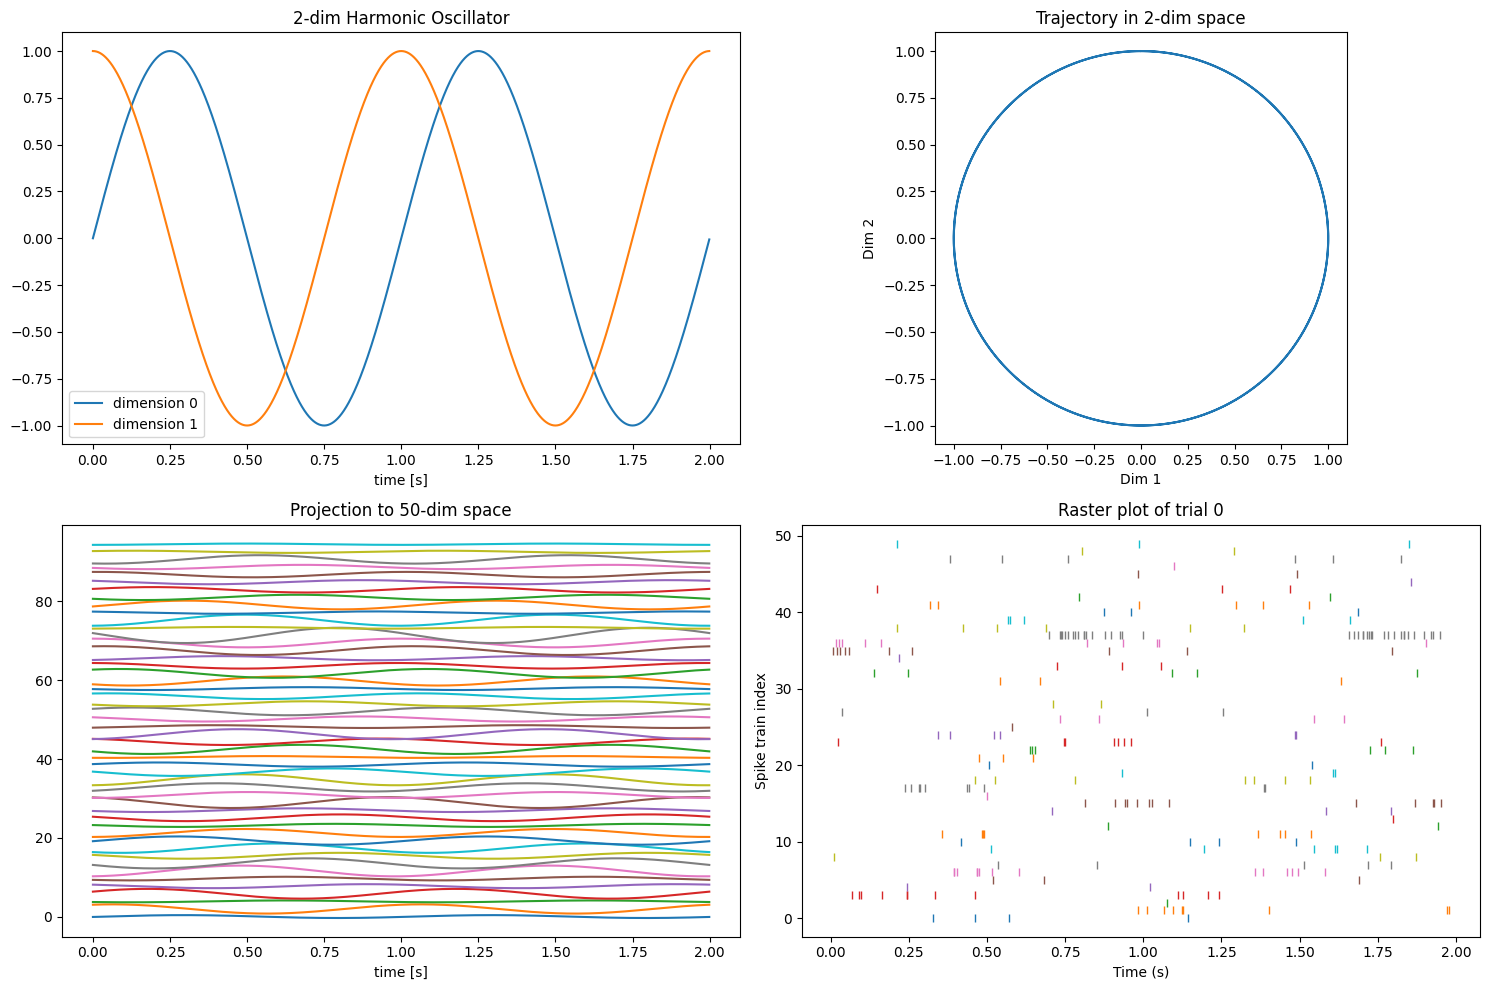

In [18]:
import matplotlib.pyplot as plt


f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

ax1.set_title('2-dim Harmonic Oscillator')
ax1.set_xlabel('time [s]')
for i, y in enumerate(oscillator_trajectory_2dim):
    ax1.plot(times_oscillator, y, label=f'dimension {i}')
ax1.legend()

ax2.set_title('Trajectory in 2-dim space')
ax2.set_xlabel('Dim 1')
ax2.set_ylabel('Dim 2')
ax2.set_aspect(1)
ax2.plot(oscillator_trajectory_2dim[0], oscillator_trajectory_2dim[1])

ax3.set_title(f'Projection to {num_spiketrains}-dim space')
ax3.set_xlabel('time [s]')
y_offset = oscillator_trajectory_Ndim.std() * 3
for i, y in enumerate(oscillator_trajectory_Ndim):
    ax3.plot(times_oscillator, y + i*y_offset)

trial_to_plot = 0
ax4.set_title(f'Raster plot of trial {trial_to_plot}')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Spike train index')
for i, spiketrain in enumerate(spiketrains_oscillator[trial_to_plot]):
    ax4.plot(spiketrain, np.ones_like(spiketrain) * i, ls='', marker='|')

plt.tight_layout()
plt.show()

### Run EM for GPFA

In [ ]:
def train_gpfa(seq_train: np.recarray, x_dim: int, bin_width: float = 20.0, 
               start_tau: float = 100.0, start_eps: float = 1e-3, 
               em_max_iters: int = 500, em_tol: float = 1e-8,
               min_var_frac: float = 0.01, freq_ll: int = 5,
               verbose: bool = False) -> tuple:
    """
    Train GPFA model using Expectation-Maximization algorithm.
    """
    
    # Get dimensions
    y_all = np.hstack([trial.y for trial in seq_train])
    y_dim = y_all.shape[0]
    N = len(seq_train)
    
    # Initialize state model parameters
    params = {
        'cov_type': 'rbf',
        # GP timescale params (gamma = (bin_width/tau)^2)
        'tau': np.ones(x_dim) * start_tau,  # Store tau directly instead of gamma
        # GP noise variance
        'eps': np.ones(x_dim) * start_eps,
        # Observation model parameters
        'd': np.mean(y_all, axis=1),
        'C': np.random.randn(y_dim, x_dim) * np.sqrt(1.0/x_dim),
        'R': np.eye(y_dim)
    }
    
    # Initialize FA to get C and R
    # TODO: Implement initialization of C and R using factor analysis
    # print("Initializing parameters using factor analysis...")
    # fa_params = fit_fa(y_all, x_dim)
    # params['C'] = fa_params['L'] 
    # params['R'] = np.diag(fa_params['Ph'])
    
    # Set minimum private variance
    var_floor = min_var_frac * np.diag(np.cov(y_all))
    
    # Initialize loop variables
    LL = []
    LL_i = float('-inf')
    iter_time = []
    
    # EM iterations
    for i in range(em_max_iters):
        if verbose:
            print(f"\nEM iteration {i+1} of {em_max_iters}")
            
        t_start = time.time()
        
        # Determine if we compute likelihood this iteration
        get_ll = (i % freq_ll == 0) or (i < 2)
        
        # ==== E-step ====
        if not np.isnan(LL_i):
            LL_old = LL_i
            
        # Run E-step for each trial
        for trial in seq_train:
            # Get time points for this trial
            T = trial.T
            t = np.arange(T)
            t1_t2_diff = t[:, None] - t[None, :]
            
            # Run E-step inference
            trial.xsm, trial.Vsm = e_step(trial.y, params['C'], params['d'], 
                                        params['R'], params['tau'], t1_t2_diff)
            
        # ==== M-step ====
        # Run M-step to update parameters
        params = m_step(seq_train, params, var_floor)
        
        # Compute log likelihood if needed
        if get_ll:
            LL_i = compute_log_likelihood(seq_train, params) # Not implemented yet. Will integrate with Shijie...
            LL.append(LL_i)
        
        t_end = time.time()
        iter_time.append(t_end - t_start)
        
        # Display progress
        if verbose and get_ll:
            print(f"Log likelihood: {LL_i:.1f} ({iter_time[-1]:.1f} sec)")
            
        # Check convergence
        if i <= 1:
            LL_base = LL_i
        elif LL_i < LL_old:
            print(f"\nError: Log likelihood decreased from {LL_old:.1f} to {LL_i:.1f}")
            break
        elif (LL_i - LL_base) < (1 + em_tol) * (LL_old - LL_base):
            if verbose:
                print(f"\nConverged after {i+1} EM iterations")
            break
            
    if np.any(np.diag(params['R']) == var_floor):
        print("Warning: Private variance floor used for one or more observed dimensions")
        
    return params, seq_train, LL, iter_time

In [30]:
# Load the MATLAB file
mat_data = sio.loadmat('gpfa_v0203/mat_sample/sample_dat.mat')

# Print keys to see what's available in the file
print("Keys in the MATLAB file:", mat_data.keys())

# Convert the data to a more usable format
# This will depend on the exact structure of the mat file
# For example, if there's a 'data' key:
if 'dat' in mat_data:
    # Convert to a numpy recarray
    raw_data = mat_data['dat']
    # Create a structured array with appropriate field names
    # Assuming the MATLAB structure has fields like 'trialId', 'spikes', etc.
    # You'll need to adjust these field names based on the actual data structure
    dtype = [('trialId', 'i4'), ('spikes', 'O'), ('timePoints', 'O')]
    sample_data = np.array([(i, d[0], d[1]) for i, d in enumerate(raw_data)], dtype=dtype)
    # Convert to recarray for attribute-style access
    sample_data = sample_data.view(np.recarray)
    print(f"Sample data shape: {sample_data.shape}")


Keys in the MATLAB file: dict_keys(['__header__', '__version__', '__globals__', 'dat'])
Sample data shape: (1,)
